# Import Dependencies

In [1]:
# data and linear algebra libraries
import pandas as pd
import numpy as np
# Graphics
import matplotlib.pyplot as plt
import seaborn as sns
# custom functions
from utils.data_processing import data_preprocessing, remove_extreme_values, split_data, feature_engineering
from utils.model_analysis import display_anova_table, residuals_analysis, find_highest_p_value, prediction_residuals_and_errors
# Generalized Linear Models Libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Competition Performance metric
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Convert to Latex Tables
from tabulate import tabulate
# MLFlow 
import mlflow
import mlflow.statsmodels
import mlflow.data

# Import Data

In [2]:
# import data from .csv
path_to_data = 'data/train.csv'
data = pd.read_csv(path_to_data)

# Process dara and add aditional financial related features
data = data_preprocessing(data)
data = feature_engineering(data)

# Add clusters
path_to_clusters = 'data/cluster_labels.csv'
cluster_labels = pd.read_csv(path_to_clusters)

# Merge clusters onto data
data = pd.merge(data, cluster_labels, on='stock_id', how='left')
# One-hot encode clusters
data = pd.get_dummies(data, columns=['cluster'], prefix='cluster')

In [3]:
data.head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,reference_price,matched_size,far_price,near_price,bid_price,bid_size,...,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9
0,0,0,0,3180602.69,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,...,False,False,False,False,True,False,False,False,False,False
1,1,0,0,166603.91,0.999896,1642214.25,0.0,0.0,0.999896,3233.04,...,False,False,True,False,False,False,False,False,False,False
2,2,0,0,302879.87,0.999561,1819368.03,0.0,0.0,0.999403,37956.00,...,False,False,False,False,False,False,False,True,False,False
3,3,0,0,11917682.27,1.000171,18389745.62,0.0,0.0,0.999999,2324.90,...,False,False,False,False,True,False,False,False,False,False
4,4,0,0,447549.96,0.999532,17860614.95,0.0,0.0,0.999394,16485.54,...,False,False,False,False,True,False,False,False,False,False


# Train-Test Split

In [4]:
# train test split 80/20% of days (test on last 20% of days)
train_data, test_data = split_data(data, int(0.8*481))

X_test = test_data.drop(columns=['target'])
y_test = test_data.target

# Constructing a dataset from a Pandas DataFrame
dataset = mlflow.data.from_pandas(train_data, name='Full Dataset Train')
# Logging dataset input	mlflow.log_input(dataset)

/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]


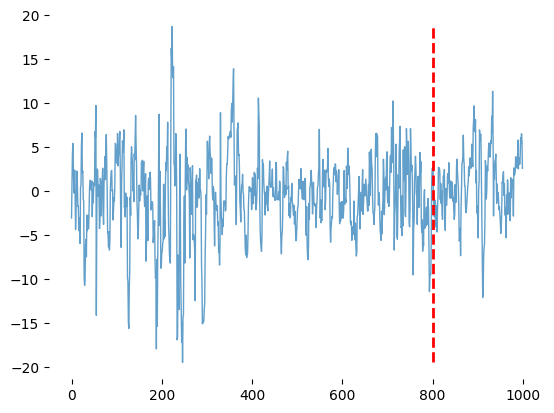

In [5]:
example_data = train_data[train_data['stock_id']==0].target.reset_index(drop=True)

truncate = 1000
max_val  = np.max(example_data[:truncate])
min_val  = np.min(example_data[:truncate])

split_point = int(0.8*truncate)

plt.plot(example_data[:truncate], alpha=0.7, lw=1)
plt.vlines(split_point, min_val, max_val, lw=2, ls='--', color='red')

# Remove spines
spines = ['top', 'bottom', 'left', 'right']
ax = plt.gca()
for spine in spines:
    ax.spines[spine].set_visible(False)

plt.show()

# MLFlow Setup

In [6]:
mlflow.set_tracking_uri('sqlite:///mlflow.db')
mlflow.set_experiment('Optiver')

<Experiment: artifact_location='/Users/thomasgaehtgens/Documents/GLS./MLFLOW/mlruns/1', creation_time=1704993617285, experiment_id='1', last_update_time=1704993617285, lifecycle_stage='active', name='Optiver', tags={}>

# Baseline Score

In [7]:
with mlflow.start_run(run_name='Baseline - Median Value'):
    mlflow.set_tag('model_name', 'Baseline')
    # compute MAE
    baseline_score = mean_absolute_error(y_test, train_data.target.median()*np.ones(len(y_test)))
    # compute MSE
    baseline_mse   = mean_squared_error(y_test, train_data.target.median()*np.ones(len(y_test)))
    # log dataset
    mlflow.log_input(dataset)
    # log metrics
    mlflow.log_metric('test_mae', baseline_score)
    mlflow.log_metric('test_mse', baseline_mse)
    
    print(f'Baseline score: {baseline_score}')

Baseline score: 6.061381271349427


/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  return _infer_schema(self._df)


# Full Model

In [8]:
# mlflow.statsmodels.autolog(disable=True)
mlflow.statsmodels.autolog(log_models=False)

with mlflow.start_run(run_name='Linear Model - Baseline'):
    mlflow.set_tag('model_name', 'baseline_linear_model')
    
    formula = 'target ~ imbalance_size + reference_price + matched_size + bid_price + bid_size + ask_price + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + imbalance_flag_1 + seconds_in_bucket + far_price + near_price' 
    
    # Fit the model on training data
    model_v1 = smf.ols(formula, 
                       data=train_data)
    
    model_v1 = model_v1.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v1, 'Full Model') # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(dataset)

    # compute and log test set metrics
    y_pred_v1 = model_v1.predict(X_test)
    
    v1_mae = mean_absolute_error(y_test, y_pred_v1)
    v1_mse = mean_squared_error(y_test, y_pred_v1)

    mlflow.log_metric('test_mae', v1_mae)
    mlflow.log_metric('test_mse', v1_mse)
    
model_v1.summary()

2024/01/11 20:50:20 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of statsmodels. If you encounter errors during autologging, try upgrading / downgrading statsmodels to a supported version, or try upgrading MLflow.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     8927.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:50:34   Log-Likelihood:            -1.5280e+07
No. Observations:             4170980   AIC:                         3.056e+07
Df Residuals:                 4170966   BIC:                         3.056e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       75.1225      1.370     54.850      0.000      72.438      77.807
imbalance_flag_neg_1[T.True]    25.0156      0.456     54.863      0.000      24.122      25.909
imbalance_flag_0[T.True]        25.0168      0.457     54.795      0.000      24.122      25.912
imbalance_flag_1[T.True]        25.0900      0.457     54.871      0.000      24.194      25.986
imbalance_size               -7.087e-11   2.68e-10     -0.265      0.791   -5.95e-10    4.54e-10
reference_price               1498.5934     15.807     94.805      0.000    1467.612    1529.575
matched_size                  1.353e-10   3.93e-11      3.440      0.001    5.82e-11    2.12e-10
bid_price                     2547.5001     15.399    165.434      0.000    2517.319    2577.681
bid_size                      8.113e-07   4.47e-08     18.153      0.000    7.24e-07    8.99e-07
ask_price                     2662.1706     15.297    174.031      0.000    2632.189    2692.152
ask_size                     -7.171e-07   3.81e-08    -18.824      0.000   -7.92e-07   -6.42e-07
wap                          -6808.4123     21.165   -321.687      0.000   -6849.894   -6766.930
seconds_in_bucket               -0.0009   5.82e-05    -16.249      0.000      -0.001      -0.001
far_price                       -0.0226      0.008     -2.675      0.007      -0.039      -0.006
near_price                       0.3061      0.020     15.183      0.000       0.267       0.346
==============================================================================
Omnibus:                  1105215.433   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         94740174.796
Skew:                           0.208   Prob(JB):                         0.00
Kurtosis:                      26.344   Cond. No.                     1.95e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.31e-16. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [9]:
display_anova_table(model_v1)

Analysis of Variance Table

+----------------------+---------+-----------+---------+----------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F     |  PR(>F)   |
+----------------------+---------+-----------+---------+----------+-----------+
| imbalance_flag_neg_1 |    1    |   85019   |  85019  |  955.2   | 1.04e-209 |
|   imbalance_flag_0   |    1    |   25793   |  25793  |  289.8   | 5.53e-65  |
|   imbalance_flag_1   |    1    |    40     |   40    |   0.5    | 5.02e-01  |
|    imbalance_size    |    1    |    122    |   122   |   1.4    | 2.41e-01  |
|   reference_price    |    1    |  177326   | 177326  |  1992.3  | 0.00e+00  |
|     matched_size     |    1    |    376    |   376   |   4.2    | 3.98e-02  |
|      bid_price       |    1    |  359224   | 359224  |  4035.9  | 0.00e+00  |
|       bid_size       |    1    |  152585   | 152585  |  1714.3  | 0.00e+00  |
|      ask_price       |    1    |  119166   | 119166  |  1338.8  | 4.57e-293 |
|       ask_

## Residuals

Lilliefors Statistic: 0.0716046451977026
P-value: 0.0009999999999998899


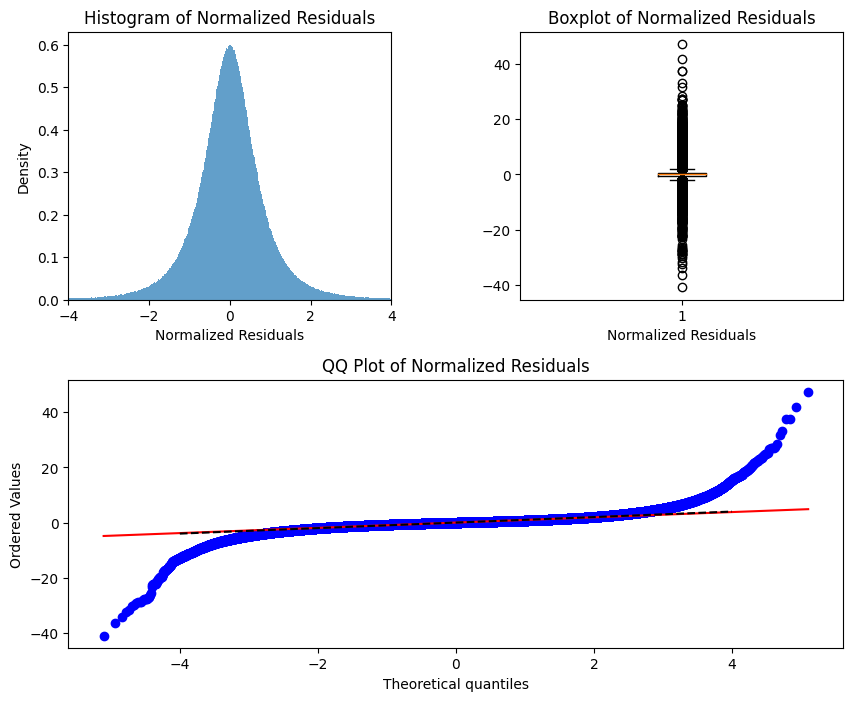

In [10]:
residuals_analysis(model_v1.resid)

## Cook's Distance

In [11]:
# Calculate Cook's distances
influence = model_v1.get_influence()
cooks_distances = influence.cooks_distance[0]

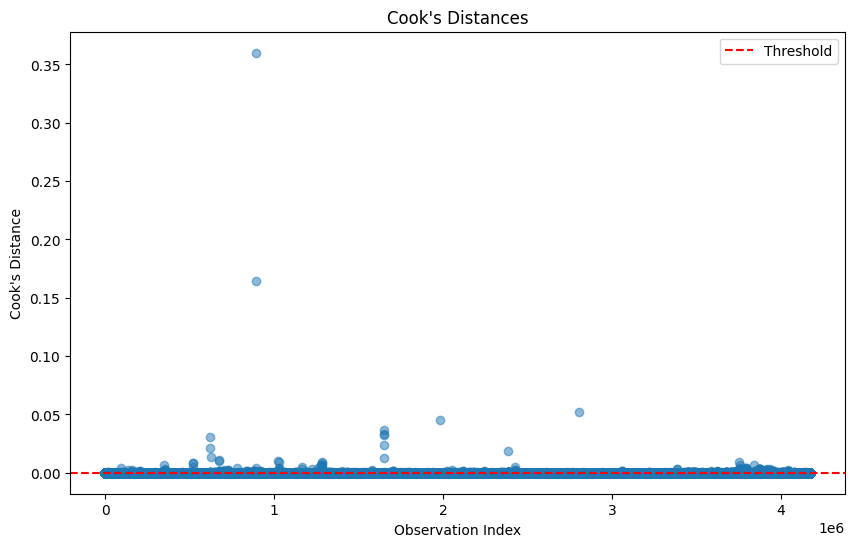

In [12]:
# Plot Cook's distances
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(cooks_distances)), cooks_distances, alpha=0.5)
plt.axhline(y=4/len(cooks_distances), color='red', linestyle='--', label='Threshold')
# plt.ylim(0, 4/len(cooks_distances) + 1e-4)
plt.title("Cook's Distances")
plt.xlabel('Observation Index')
plt.ylabel("Cook's Distance")
plt.legend()
plt.show()

In [13]:
# Set threshold
threshold = 4 / len(model_v1.fittedvalues)

# Identify influential observations
influential_observations = np.where(cooks_distances > threshold)[0]

We now remove the points that have 'too much' influence 

In [14]:
new_train_data = train_data.drop(index=influential_observations)

n_removed = len(train_data) - len(new_train_data)
p_removed = round(100 * n_removed/len(train_data), 2)

print(f'{n_removed} points were removed! that is {p_removed}% of the original training data!')

172359 points were removed! that is 4.13% of the original training data!


Fit the model the the dataset without these points

In [15]:
cook_full_dataset = mlflow.data.from_pandas(train_data, name="Cook's Dataset Train")

with mlflow.start_run(run_name="Linear Model - Baseline w Cook's Distance"):
    mlflow.set_tag('model_name', 'baseline_cook_linear_model')
    
    formula = 'target ~ imbalance_size + reference_price + matched_size + bid_price + bid_size + ask_price + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + imbalance_flag_1 + seconds_in_bucket + far_price + near_price' 
    
    # Fit the model on training data
    model_v2 = smf.ols(formula, 
                       data=new_train_data)
    
    model_v2 = model_v2.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v2, "Full Model - Cook's Distance") # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(cook_full_dataset)
    
    # compute and log test set metrics
    y_pred_v2 = model_v2.predict(X_test)
    
    v2_mae = mean_absolute_error(y_test, y_pred_v2)
    v2_mse = mean_squared_error(y_test, y_pred_v2)

    mlflow.log_metric('test_mae', v2_mae)
    mlflow.log_metric('test_mse', v2_mse)
    
model_v2.summary()

/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.037
Model:                            OLS   Adj. R-squared:                  0.037
Method:                 Least Squares   F-statistic:                 1.176e+04
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:52:34   Log-Likelihood:            -1.3628e+07
No. Observations:             3998621   AIC:                         2.726e+07
Df Residuals:                 3998607   BIC:                         2.726e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       48.6131      1.164     41.778      0.000      46.332      50.894
imbalance_flag_neg_1[T.True]    16.2085      0.387     41.838      0.000      15.449      16.968
imbalance_flag_0[T.True]        16.2062      0.388     41.781      0.000      15.446      16.966
imbalance_flag_1[T.True]        16.1983      0.388     41.702      0.000      15.437      16.960
imbalance_size               -1.046e-09   2.85e-10     -3.672      0.000    -1.6e-09   -4.88e-10
reference_price               1534.2970     15.035    102.048      0.000    1504.829    1563.765
matched_size                  2.341e-10   3.97e-11      5.901      0.000    1.56e-10    3.12e-10
bid_price                     2869.2301     14.798    193.896      0.000    2840.227    2898.233
bid_size                       1.78e-06      5e-08     35.612      0.000    1.68e-06    1.88e-06
ask_price                     2950.4969     14.756    199.947      0.000    2921.575    2979.419
ask_size                     -1.839e-06   4.81e-08    -38.232      0.000   -1.93e-06   -1.74e-06
wap                          -7418.7829     20.341   -364.713      0.000   -7458.651   -7378.914
seconds_in_bucket               -0.0013   4.66e-05    -27.809      0.000      -0.001      -0.001
far_price                       -0.0807      0.043     -1.859      0.063      -0.166       0.004
near_price                       0.4647      0.045     10.431      0.000       0.377       0.552
==============================================================================
Omnibus:                    70784.814   Durbin-Watson:                   1.948
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           147198.409
Skew:                           0.006   Prob(JB):                         0.00
Kurtosis:                       3.940   Cond. No.                     9.18e+19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.7e-18. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [16]:
display_anova_table(model_v2)

Analysis of Variance Table

+----------------------+---------+-----------+---------+----------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F     |  PR(>F)   |
+----------------------+---------+-----------+---------+----------+-----------+
| imbalance_flag_neg_1 |    1    |   65384   |  65384  |  1223.8  | 4.43e-268 |
|   imbalance_flag_0   |    1    |   11940   |  11940  |  223.5   | 1.57e-50  |
|   imbalance_flag_1   |    1    |     0     |    0    |   0.0    | 9.75e-01  |
|    imbalance_size    |    1    |    129    |   129   |   2.4    | 1.19e-01  |
|   reference_price    |    1    |   67720   |  67720  |  1267.6  | 1.40e-277 |
|     matched_size     |    1    |   1061    |  1061   |   19.9   | 8.33e-06  |
|      bid_price       |    1    |  195364   | 195364  |  3656.7  | 0.00e+00  |
|       bid_size       |    1    |  204741   | 204741  |  3832.2  | 0.00e+00  |
|      ask_price       |    1    |   71186   |  71186  |  1332.4  | 1.14e-291 |
|       ask_

Lilliefors Statistic: 0.030926493947807
P-value: 0.0009999999999998899


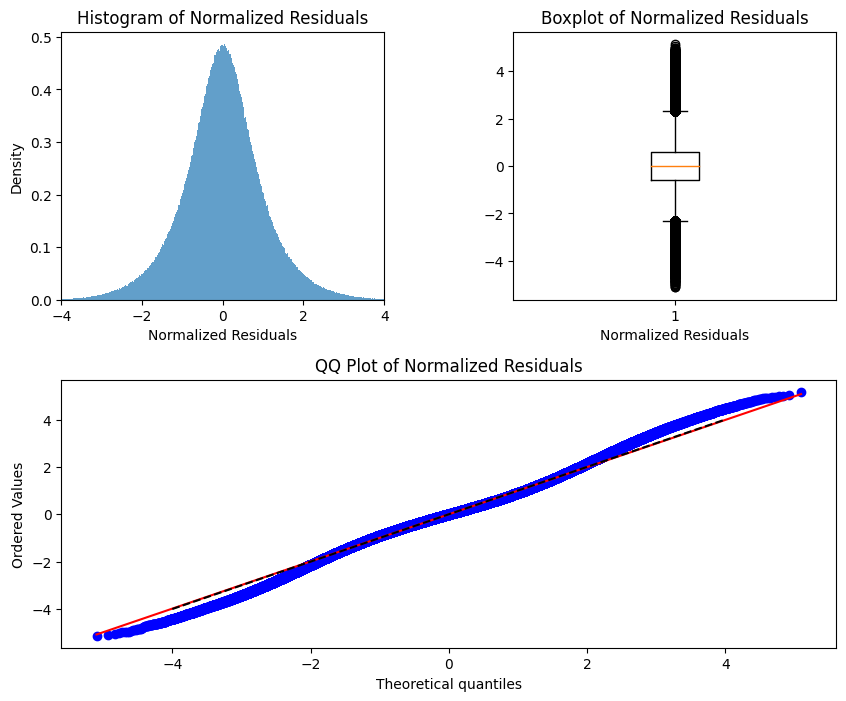

In [17]:
residuals_analysis(model_v2.resid)

# Stepwise Regression

### Full Model

In [18]:
display_anova_table(model_v1)
find_highest_p_value(model_v1)

Analysis of Variance Table

+----------------------+---------+-----------+---------+----------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F     |  PR(>F)   |
+----------------------+---------+-----------+---------+----------+-----------+
| imbalance_flag_neg_1 |    1    |   85019   |  85019  |  955.2   | 1.04e-209 |
|   imbalance_flag_0   |    1    |   25793   |  25793  |  289.8   | 5.53e-65  |
|   imbalance_flag_1   |    1    |    40     |   40    |   0.5    | 5.02e-01  |
|    imbalance_size    |    1    |    122    |   122   |   1.4    | 2.41e-01  |
|   reference_price    |    1    |  177326   | 177326  |  1992.3  | 0.00e+00  |
|     matched_size     |    1    |    376    |   376   |   4.2    | 3.98e-02  |
|      bid_price       |    1    |  359224   | 359224  |  4035.9  | 0.00e+00  |
|       bid_size       |    1    |  152585   | 152585  |  1714.3  | 0.00e+00  |
|      ask_price       |    1    |  119166   | 119166  |  1338.8  | 4.57e-293 |
|       ask_

### Step 1

In [19]:
# Remove immbalance_flag_1
formula_step = 'target ~ cluster_0 + cluster_1 + cluster_2 + cluster_3 + cluster_4 + cluster_5 + cluster_6 + cluster_7 + cluster_8 + cluster_9 + liquidity_imbalance + matched_imbalance + price_spread + market_urgency + imbalance_size + reference_price + matched_size + bid_price + bid_size + ask_price + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + seconds_in_bucket + far_price + near_price'

# Fit the model on training data
model_step = smf.ols(formula_step, 
                   data=train_data)

model_step = model_step.fit()

display_anova_table(model_step)
find_highest_p_value(model_step)

2024/01/11 20:53:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '30819aacc1944d6d859b4b66a6f6922a', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


Analysis of Variance Table

+----------------------+---------+-----------+---------+---------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F    |  PR(>F)   |
+----------------------+---------+-----------+---------+---------+-----------+
|      cluster_0       |    1    |   7901    |  7901   |  88.8   | 4.35e-21  |
|      cluster_1       |    1    |   3519    |  3519   |  39.6   | 3.18e-10  |
|      cluster_2       |    1    |   20255   |  20255  |  227.7  | 1.93e-51  |
|      cluster_3       |    1    |    143    |   143   |   1.6   | 2.04e-01  |
|      cluster_4       |    1    |   16423   |  16423  |  184.6  | 4.80e-42  |
|      cluster_5       |    1    |   3204    |  3204   |  36.0   | 1.95e-09  |
|      cluster_6       |    1    |   2062    |  2062   |  23.2   | 1.47e-06  |
|      cluster_7       |    1    |   4381    |  4381   |  49.2   | 2.26e-12  |
|      cluster_8       |    1    |   12969   |  12969  |  145.8  | 1.46e-33  |
|      cluster_9       |

### Step 2

In [20]:
# Remove cluster_9
formula_step = 'target ~ cluster_0 + cluster_1 + cluster_2 + cluster_3 + cluster_4 + cluster_5 + cluster_6 + cluster_7 + cluster_8 + liquidity_imbalance + matched_imbalance + price_spread + market_urgency + imbalance_size + reference_price + matched_size + bid_price + bid_size + ask_price + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + seconds_in_bucket + far_price + near_price'

# Fit the model on training data
model_step = smf.ols(formula_step, 
                   data=train_data)

model_step = model_step.fit()

display_anova_table(model_step)
find_highest_p_value(model_step)

2024/01/11 20:54:21 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '8a24312a239340a8b02dd7ad00ec23f6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


Analysis of Variance Table

+----------------------+---------+-----------+---------+---------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F    |  PR(>F)   |
+----------------------+---------+-----------+---------+---------+-----------+
|      cluster_0       |    1    |   7901    |  7901   |  88.8   | 4.35e-21  |
|      cluster_1       |    1    |   3519    |  3519   |  39.6   | 3.18e-10  |
|      cluster_2       |    1    |   20255   |  20255  |  227.7  | 1.93e-51  |
|      cluster_3       |    1    |    143    |   143   |   1.6   | 2.04e-01  |
|      cluster_4       |    1    |   16423   |  16423  |  184.6  | 4.80e-42  |
|      cluster_5       |    1    |   3204    |  3204   |  36.0   | 1.95e-09  |
|      cluster_6       |    1    |   2062    |  2062   |  23.2   | 1.47e-06  |
|      cluster_7       |    1    |   4381    |  4381   |  49.2   | 2.26e-12  |
|      cluster_8       |    1    |   12969   |  12969  |  145.8  | 1.46e-33  |
| imbalance_flag_neg_1 |

### Step 3

In [21]:
# Remove ask_price
formula_step = 'target ~ cluster_0 + cluster_1 + cluster_2 + cluster_3 + cluster_4 + cluster_5 + cluster_6 + cluster_7 + cluster_8 + liquidity_imbalance + matched_imbalance + price_spread + market_urgency + imbalance_size + reference_price + matched_size + bid_price + bid_size + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + seconds_in_bucket + far_price + near_price'

# Fit the model on training data
model_step = smf.ols(formula_step, 
                   data=train_data)

model_step = model_step.fit()

display_anova_table(model_step)
find_highest_p_value(model_step)

2024/01/11 20:55:09 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'c3601e4939f2455a92bd870761e0cf72', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


Analysis of Variance Table

+----------------------+---------+-----------+---------+---------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F    |  PR(>F)   |
+----------------------+---------+-----------+---------+---------+-----------+
|      cluster_0       |    1    |   7901    |  7901   |  88.8   | 4.35e-21  |
|      cluster_1       |    1    |   3519    |  3519   |  39.6   | 3.18e-10  |
|      cluster_2       |    1    |   20255   |  20255  |  227.7  | 1.93e-51  |
|      cluster_3       |    1    |    143    |   143   |   1.6   | 2.04e-01  |
|      cluster_4       |    1    |   16423   |  16423  |  184.6  | 4.80e-42  |
|      cluster_5       |    1    |   3204    |  3204   |  36.0   | 1.95e-09  |
|      cluster_6       |    1    |   2062    |  2062   |  23.2   | 1.47e-06  |
|      cluster_7       |    1    |   4381    |  4381   |  49.2   | 2.26e-12  |
|      cluster_8       |    1    |   12969   |  12969  |  145.8  | 1.46e-33  |
| imbalance_flag_neg_1 |

### Step 4

In [22]:
# Remove cluster_3
formula_step = 'target ~ cluster_0 + cluster_1 + cluster_2 + cluster_4 + cluster_5 + cluster_6 + cluster_7 + cluster_8 + liquidity_imbalance + matched_imbalance + price_spread + market_urgency + imbalance_size + reference_price + matched_size + bid_price + bid_size + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + seconds_in_bucket + far_price + near_price'

# Fit the model on training data
model_step = smf.ols(formula_step, 
                   data=train_data)

model_step = model_step.fit()

display_anova_table(model_step)
find_highest_p_value(model_step)

2024/01/11 20:55:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '827469f8c25e40f0ac45a8be2c2294a4', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current statsmodels workflow


Analysis of Variance Table

+----------------------+---------+-----------+---------+---------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F    |  PR(>F)   |
+----------------------+---------+-----------+---------+---------+-----------+
|      cluster_0       |    1    |   7901    |  7901   |  88.8   | 4.36e-21  |
|      cluster_1       |    1    |   3519    |  3519   |  39.6   | 3.18e-10  |
|      cluster_2       |    1    |   20255   |  20255  |  227.7  | 1.94e-51  |
|      cluster_4       |    1    |   8094    |  8094   |  91.0   | 1.45e-21  |
|      cluster_5       |    1    |   4862    |  4862   |  54.7   | 1.44e-13  |
|      cluster_6       |    1    |   4375    |  4375   |  49.2   | 2.34e-12  |
|      cluster_7       |    1    |    795    |   795   |   8.9   | 2.79e-03  |
|      cluster_8       |    1    |   1946    |  1946   |  21.9   | 2.90e-06  |
| imbalance_flag_neg_1 |    1    |   77732   |  77732  |  873.7  | 5.43e-192 |
|   imbalance_flag_0   |

### Step 5

In [23]:
# Remove imbalance_size
formula_step = 'target ~ cluster_0 + cluster_1 + cluster_2 + cluster_4 + cluster_5 + cluster_6 + cluster_7 + cluster_8 + liquidity_imbalance + matched_imbalance + price_spread + market_urgency + reference_price + matched_size + bid_price + bid_size + ask_size + wap + imbalance_flag_neg_1 + imbalance_flag_0 + seconds_in_bucket + far_price + near_price'

with mlflow.start_run(run_name='Linear Model - Stepwise'):
    mlflow.set_tag('model_name', 'step_cook_linear_model')
    
    # Fit the model on training data
    model_step_v1 = smf.ols(formula_step, 
                       data=train_data)
    
    model_step_v1 = model_step_v1.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v1, 'Full Model') # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(dataset)

    # compute and log test set metrics
    y_pred_step = model_step_v1.predict(X_test)
    
    step_mae = mean_absolute_error(y_test, y_pred_step)
    step_mse = mean_squared_error(y_test, y_pred_step)

    mlflow.log_metric('test_mae', step_mae)
    mlflow.log_metric('test_mse', step_mse)


display_anova_table(model_step)
find_highest_p_value(model_step)


Analysis of Variance Table

+----------------------+---------+-----------+---------+---------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F    |  PR(>F)   |
+----------------------+---------+-----------+---------+---------+-----------+
|      cluster_0       |    1    |   7901    |  7901   |  88.8   | 4.36e-21  |
|      cluster_1       |    1    |   3519    |  3519   |  39.6   | 3.18e-10  |
|      cluster_2       |    1    |   20255   |  20255  |  227.7  | 1.94e-51  |
|      cluster_4       |    1    |   8094    |  8094   |  91.0   | 1.45e-21  |
|      cluster_5       |    1    |   4862    |  4862   |  54.7   | 1.44e-13  |
|      cluster_6       |    1    |   4375    |  4375   |  49.2   | 2.34e-12  |
|      cluster_7       |    1    |    795    |   795   |   8.9   | 2.79e-03  |
|      cluster_8       |    1    |   1946    |  1946   |  21.9   | 2.90e-06  |
| imbalance_flag_neg_1 |    1    |   77732   |  77732  |  873.7  | 5.43e-192 |
|   imbalance_flag_0   |

## Final Model Analysis

In [24]:
model_step_v1 = model_step
model_step_v1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     5119.
Date:                Thu, 11 Jan 2024   Prob (F-statistic):               0.00
Time:                        20:57:22   Log-Likelihood:            -1.5279e+07
No. Observations:             4170980   AIC:                         3.056e+07
Df Residuals:                 4170956   BIC:                         3.056e+07
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                       99.8236      1.828     54.623      0.000      96.242     103.405
cluster_0[T.True]                0.2151      0.026      8.330      0.000       0.165       0.266
cluster_1[T.True]                0.0816      0.016      5.067      0.000       0.050       0.113
cluster_2[T.True]                0.2215      0.019     11.649      0.000       0.184       0.259
cluster_4[T.True]               -0.0903      0.014     -6.584      0.000      -0.117      -0.063
cluster_5[T.True]                0.5178      0.067      7.678      0.000       0.386       0.650
cluster_6[T.True]                0.1416      0.040      3.503      0.000       0.062       0.221
cluster_7[T.True]                0.0519      0.019      2.690      0.007       0.014       0.090
cluster_8[T.True]               -0.2353      0.068     -3.461      0.001      -0.368      -0.102
imbalance_flag_neg_1[T.True]    -0.0833      0.012     -7.154      0.000      -0.106      -0.060
imbalance_flag_0[T.True]        -0.0168      0.014     -1.217      0.223      -0.044       0.010
liquidity_imbalance             -0.3520      0.012    -29.761      0.000      -0.375      -0.329
matched_imbalance                0.2520      0.018     14.364      0.000       0.218       0.286
price_spread                  6274.6455   3036.188      2.067      0.039     323.824    1.22e+04
market_urgency                3989.0438   3032.484      1.315      0.188   -1954.517    9932.604
imbalance_size               -8.375e-10   2.77e-10     -3.025      0.002   -1.38e-09   -2.95e-10
reference_price               1489.3739     15.819     94.150      0.000    1458.369    1520.379
matched_size                  3.452e-10   4.05e-11      8.527      0.000    2.66e-10    4.25e-10
bid_price                      1.26e+04   6064.774      2.077      0.038     711.100    2.45e+04
bid_size                      1.194e-06   4.61e-08     25.924      0.000     1.1e-06    1.28e-06
ask_size                     -9.218e-07   3.91e-08    -23.602      0.000   -9.98e-07   -8.45e-07
wap                          -1.419e+04   6064.984     -2.339      0.019   -2.61e+04   -2299.652
seconds_in_bucket               -0.0010   5.84e-05    -16.510      0.000      -0.001      -0.001
far_price                       -0.0212      0.008     -2.515      0.012      -0.038      -0.005
near_price                       0.3506      0.020     17.219      0.000       0.311       0.391
==============================================================================
Omnibus:                  1101581.393   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         94595794.660
Skew:                           0.196   Prob(JB):                         0.00
Kurtosis:                      26.327   Cond. No.  

Lilliefors Statistic: 0.07145275371364745
P-value: 0.0009999999999998899


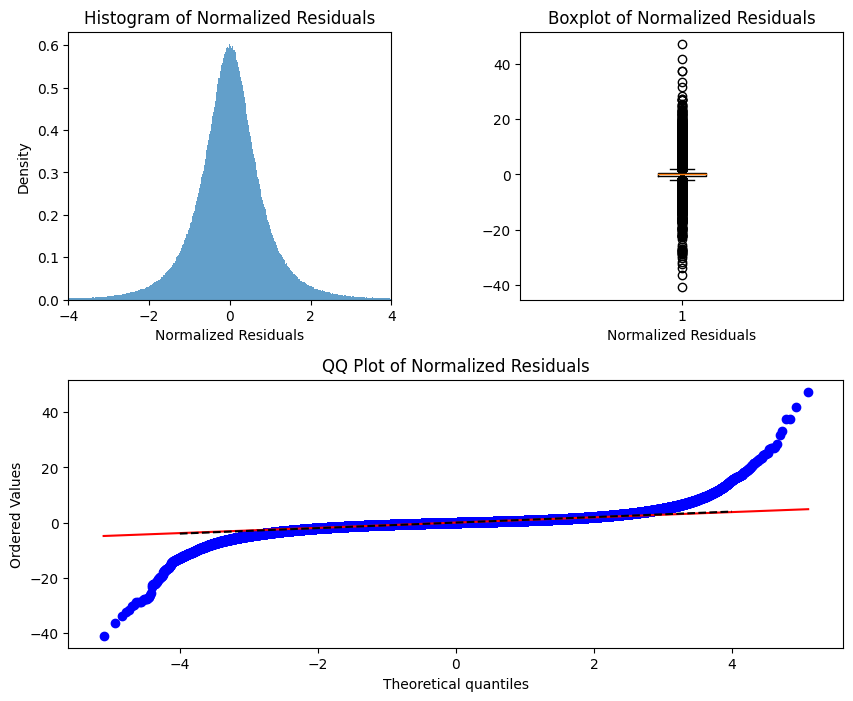

In [25]:
residuals_analysis(model_step_v1.resid)

## Cook's Distance

In [26]:
# Calculate Cook's distances
influence = model_step_v1.get_influence()
cooks_distances = influence.cooks_distance[0]

In [27]:
# Set threshold
threshold = 4 / len(model_step_v1.fittedvalues)

# Identify influential observations
influential_observations = np.where(cooks_distances > threshold)[0]

Remove Points with 'too much influence'

In [28]:
new_train_data = train_data.drop(index=influential_observations)

n_removed = len(train_data) - len(new_train_data)
p_removed = round(100 * n_removed/len(train_data), 2)

print(f'{n_removed} points were removed! that is {p_removed}% of the original training data!')

217377 points were removed! that is 5.21% of the original training data!


Fit Linear model to new dataset

In [29]:
with mlflow.start_run(run_name='Linear Model - Stepwise - Cook'):
    mlflow.set_tag('model_name', 'step_cook_linear_model')
    
    # Fit the model on training data
    model_step_v2 = smf.ols(formula_step, 
                       data=new_train_data)
    
    model_step_v2 = model_step_v2.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v1, 'Full Model') # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(dataset)

    # compute and log test set metrics
    y_pred_step_v2 = model_step_v2.predict(X_test)
    
    step_v2_mae = mean_absolute_error(y_test, y_pred_step_v2)
    step_v2_mse = mean_squared_error(y_test, y_pred_step_v2)

    mlflow.log_metric('test_mae', step_v2_mae)
    mlflow.log_metric('test_mse', step_v2_mse)


display_anova_table(model_step_v2)

Analysis of Variance Table

+----------------------+---------+-----------+---------+---------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F    |  PR(>F)   |
+----------------------+---------+-----------+---------+---------+-----------+
|      cluster_0       |    1    |   1254    |  1254   |  25.4   | 4.61e-07  |
|      cluster_1       |    1    |   1619    |  1619   |  32.8   | 1.01e-08  |
|      cluster_2       |    1    |   10986   |  10986  |  222.6  | 2.44e-50  |
|      cluster_4       |    1    |   3763    |  3763   |  76.3   | 2.48e-18  |
|      cluster_5       |    1    |   1699    |  1699   |  34.4   | 4.38e-09  |
|      cluster_6       |    1    |    655    |   655   |  13.3   | 2.68e-04  |
|      cluster_7       |    1    |   1179    |  1179   |  23.9   | 1.02e-06  |
|      cluster_8       |    1    |    411    |   411   |   8.3   | 3.88e-03  |
| imbalance_flag_neg_1 |    1    |   57092   |  57092  | 1156.9  | 1.58e-253 |
|   imbalance_flag_0   |

Lilliefors Statistic: 0.025748204398873042
P-value: 0.0009999999999998899


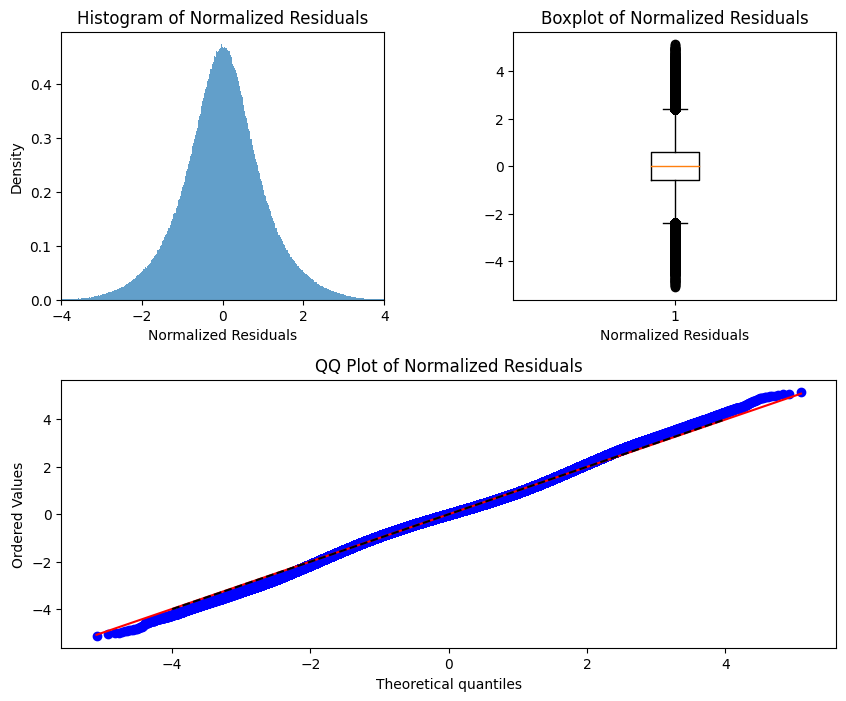

In [30]:
residuals_analysis(model_step_v2.resid)

# Prediction

### model_v1

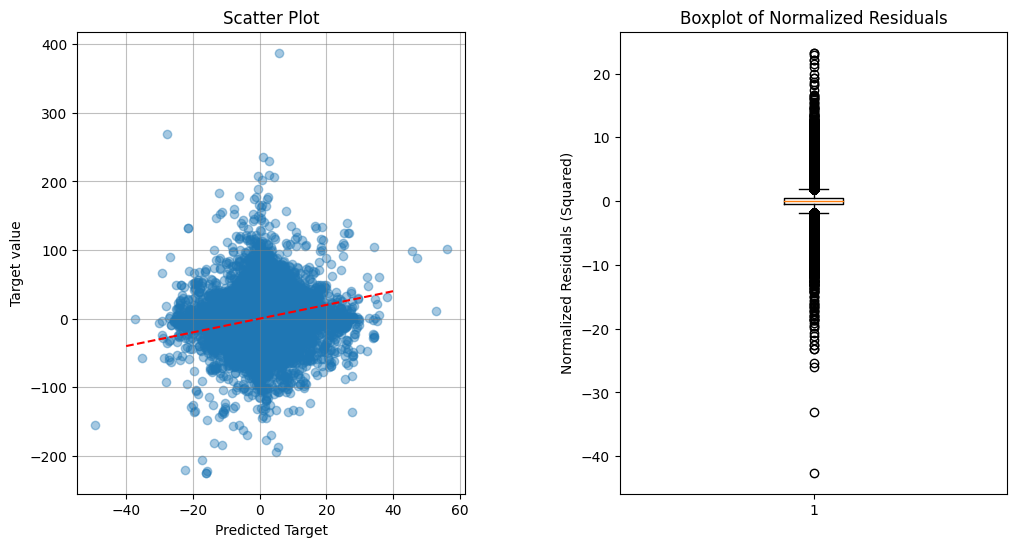

Mean Absolute Error: 6.0231
Mean Squared Error:  80.4132


In [31]:
prediction_residuals_and_errors(model_v1, X_test=X_test, y_test=y_test)

Lilliefors Statistic: 0.07394279966758818
P-value: 0.0009999999999998899


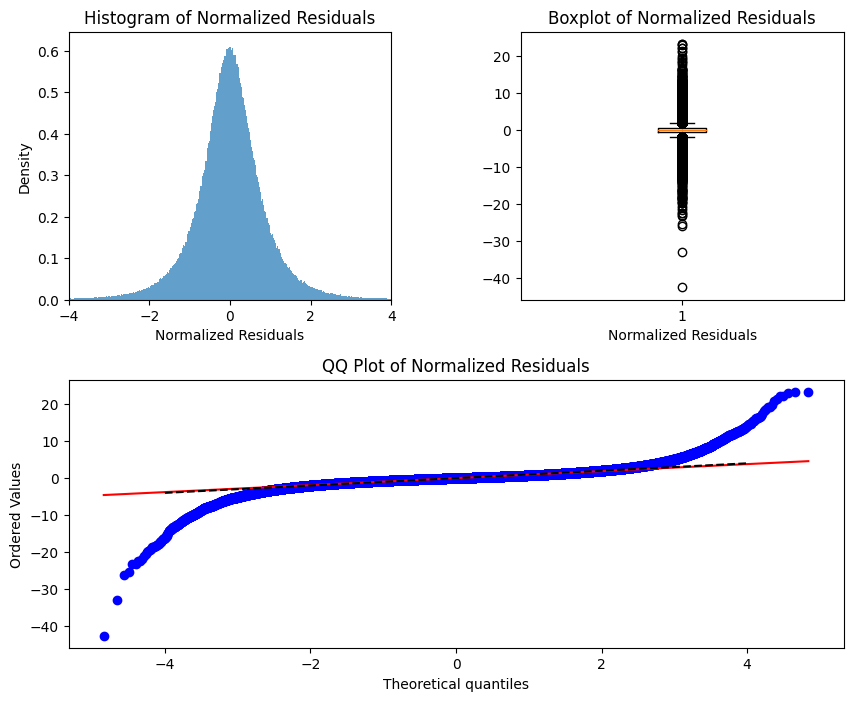

In [32]:
# Compute predictions
y_pred = model_v1.predict(X_test)

# Compute residuals
residuals = y_pred - y_test

residuals_analysis(residuals)

### model_v2

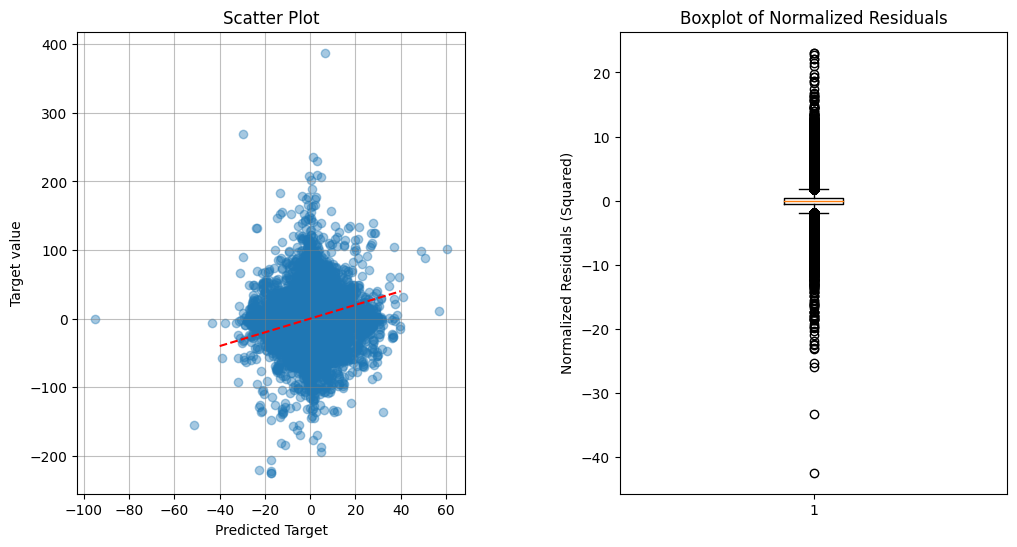

Mean Absolute Error: 6.0269
Mean Squared Error:  80.5780


In [33]:
prediction_residuals_and_errors(model_v2, X_test=X_test, y_test=y_test)

Lilliefors Statistic: 0.07419627768501835
P-value: 0.0009999999999998899


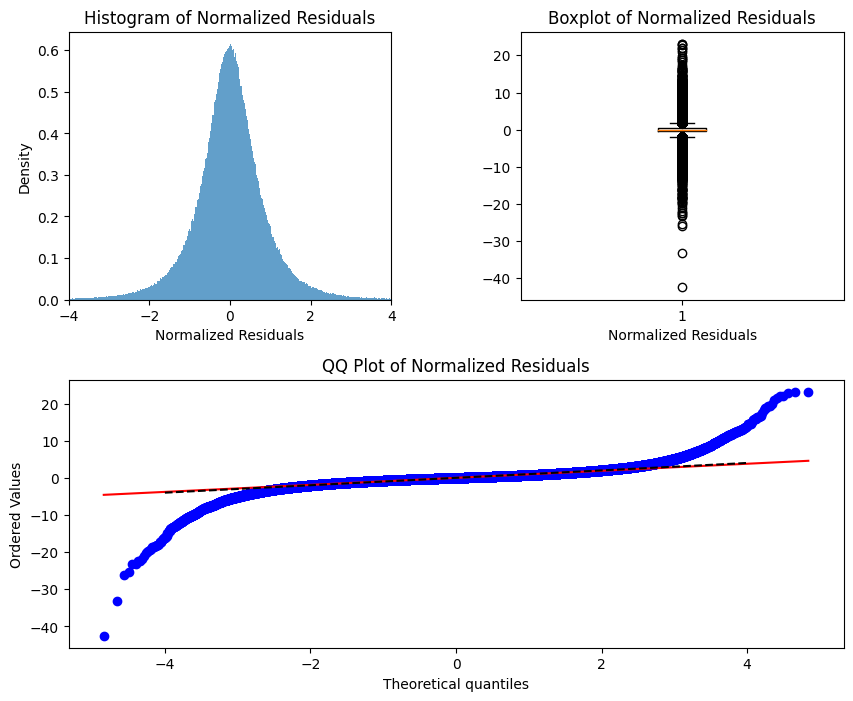

In [34]:
# Compute predictions
y_pred = model_v2.predict(X_test)

# Compute residuals
residuals = y_pred - y_test

residuals_analysis(residuals)

### model_step_v1

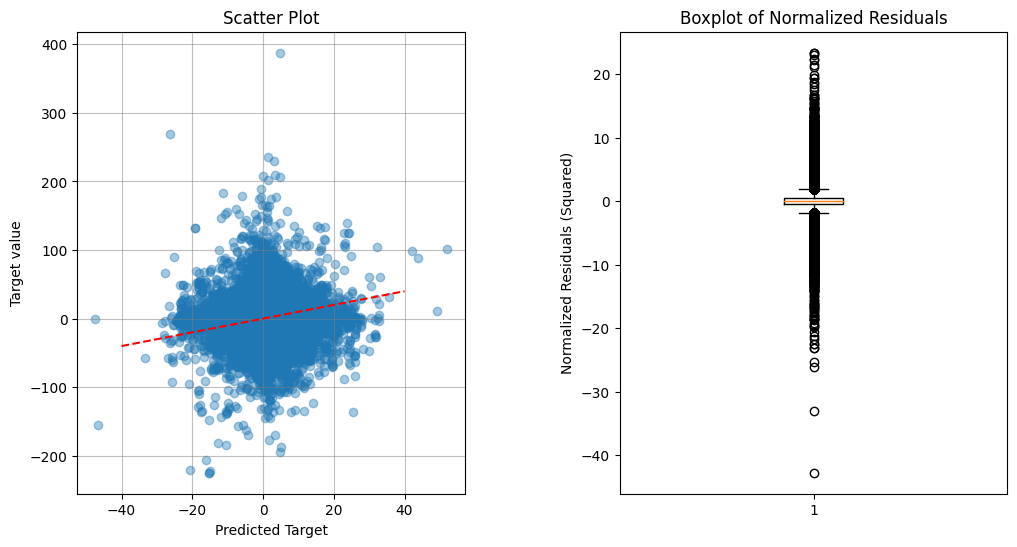

Mean Absolute Error: 6.0213
Mean Squared Error:  80.3029


In [35]:
prediction_residuals_and_errors(model_step_v1, X_test=X_test, y_test=y_test)

Lilliefors Statistic: 0.07394279966758818
P-value: 0.0009999999999998899


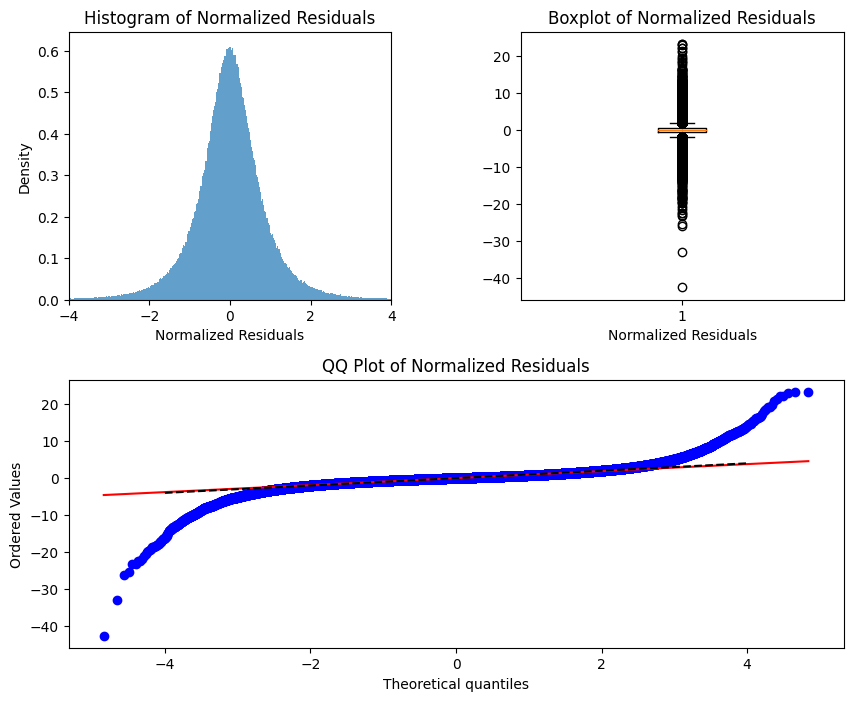

In [36]:
# Compute predictions
y_pred = model_v1.predict(X_test)

# Compute residuals
residuals = y_pred - y_test

residuals_analysis(residuals)

### model_step_v2

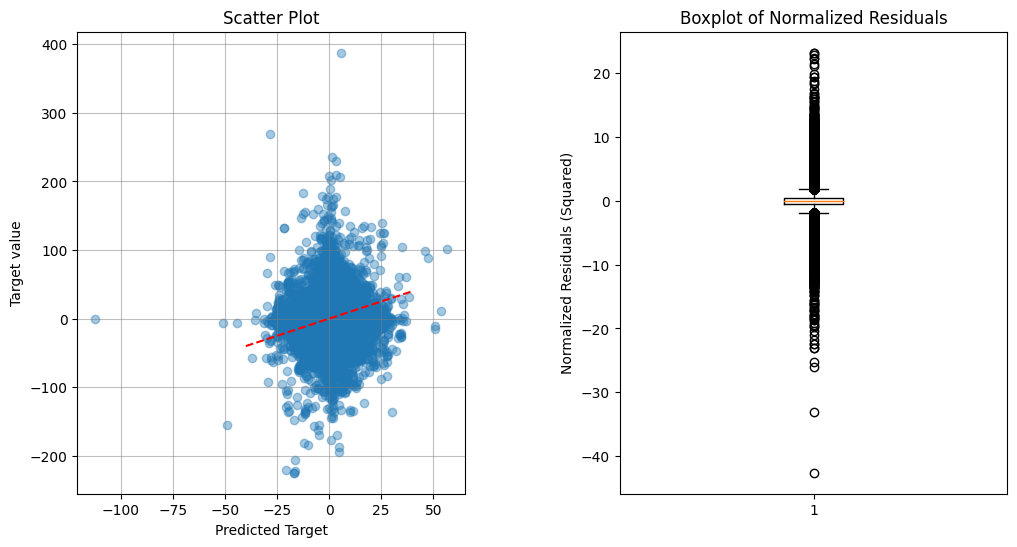

Mean Absolute Error: 6.0240
Mean Squared Error:  80.4627


In [37]:
prediction_residuals_and_errors(model_step_v2, X_test=X_test, y_test=y_test)

Lilliefors Statistic: 0.07409355422009178
P-value: 0.0009999999999998899


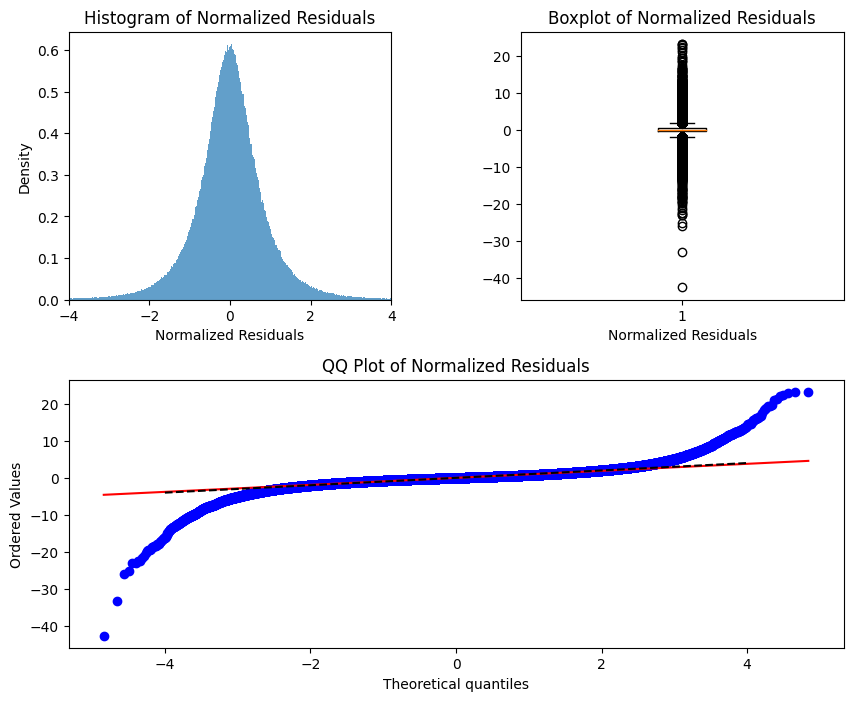

In [38]:
# Compute predictions
y_pred = model_step_v2.predict(X_test)

# Compute residuals
residuals = y_pred - y_test

residuals_analysis(residuals)

# Remove Points with 'Extreme' Target values

Another approach is to select remove from the train set the 'unlikely' target variable values. That is, exclude points outside of a given interval. We'll try this for sigma values: {1, 2, 3, 4}

Text(0.5, 0, 'Target')

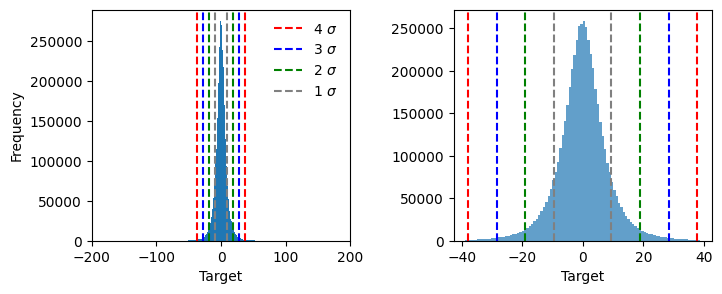

In [39]:
# Create a custom grid for subplots
plt.figure(figsize=(8, 3))
grid = plt.GridSpec(1, 2, wspace=0.4)

# Histogram with the 4-sigma vertical lines
plt.subplot(grid[0])
oi = plt.hist(data.target, bins=1000)
# Calculate mean and standard deviation
mean_target = np.mean(data.target)
std_target = np.std(data.target)
# Add vertical lines on sigmas from the mean
plt.axvline(mean_target - 4 * std_target, color='red', linestyle='--', label=r'4 $\sigma$')
plt.axvline(mean_target + 4 * std_target, color='red', linestyle='--')

plt.axvline(mean_target - 3 * std_target, color='blue', linestyle='--', label=r'3 $\sigma$')
plt.axvline(mean_target + 3 * std_target, color='blue', linestyle='--')

plt.axvline(mean_target - 2 * std_target, color='green', linestyle='--', label=r'2 $\sigma$')
plt.axvline(mean_target + 2 * std_target, color='green', linestyle='--')

plt.axvline(mean_target - 1 * std_target, color='gray', linestyle='--', label=r'1 $\sigma$')
plt.axvline(mean_target + 1 * std_target, color='gray', linestyle='--')

plt.ylabel('Frequency')
plt.xlabel('Target')

plt.xlim(-200, 200)

plt.legend(frameon=False)

# Truncated histogram
plt.subplot(grid[1])
filtered_data = data[(data.target > mean_target - 4.1 * std_target) & (data.target < mean_target + 4.1 * std_target)]
oi = plt.hist(filtered_data.target, bins=100, color='C0', alpha=0.7)
# Add vertical lines on sigmas from the mean
plt.axvline(mean_target - 4 * std_target, color='red', linestyle='--')
plt.axvline(mean_target + 4 * std_target, color='red', linestyle='--')

plt.axvline(mean_target - 3 * std_target, color='blue', linestyle='--')
plt.axvline(mean_target + 3 * std_target, color='blue', linestyle='--')

plt.axvline(mean_target - 2 * std_target, color='green', linestyle='--')
plt.axvline(mean_target + 2 * std_target, color='green', linestyle='--')

plt.axvline(mean_target - 1 * std_target, color='gray', linestyle='--')
plt.axvline(mean_target + 1 * std_target, color='gray', linestyle='--')

plt.xlabel('Target')

### 4 $\sigma$ Region

In [40]:
# Define sigma region
sigma_region = train_data[(train_data.target > mean_target - 4 * std_target) & (train_data.target < mean_target + 4 * std_target)]
# Create MLFlow dataset for log
sigma4_dataset = mlflow.data.from_pandas(sigma_region, name='Sigma 4 Dataset Train')

with mlflow.start_run(run_name='Linear Model - Sigma 4'):
    mlflow.set_tag('model_name', 'sigma_4_linear_model')
    
    # Fit the model on training data
    model_sigma4 = smf.ols(formula, 
                       data=sigma_region)
    
    model_sigma4 = model_sigma4.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v1, 'Full Model') # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(sigma4_dataset)

    # compute and log test set metrics
    y_pred_sigma = model_sigma4.predict(X_test)
    
    sigma4_mae = mean_absolute_error(y_test, y_pred_sigma)
    sigma4_mse = mean_squared_error(y_test, y_pred_sigma)

    mlflow.log_metric('test_mae', sigma4_mae)
    mlflow.log_metric('test_mse', sigma4_mse)


/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [41]:
display_anova_table(model_sigma4)

Analysis of Variance Table

+----------------------+---------+-----------+---------+----------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F     |  PR(>F)   |
+----------------------+---------+-----------+---------+----------+-----------+
| imbalance_flag_neg_1 |    1    |   74996   |  74996  |  1051.4  | 1.32e-230 |
|   imbalance_flag_0   |    1    |   17456   |  17456  |  244.7   | 3.69e-55  |
|   imbalance_flag_1   |    1    |    48     |   48    |   0.7    | 4.08e-01  |
|    imbalance_size    |    1    |    899    |   899   |   12.6   | 3.84e-04  |
|   reference_price    |    1    |  101206   | 101206  |  1418.8  | 1.95e-310 |
|     matched_size     |    1    |   1510    |  1510   |   21.2   | 4.18e-06  |
|      bid_price       |    1    |  208000   | 208000  |  2915.9  | 0.00e+00  |
|       bid_size       |    1    |  137234   | 137234  |  1923.9  | 0.00e+00  |
|      ask_price       |    1    |   99549   |  99549  |  1395.6  | 2.17e-305 |
|       ask_

Lilliefors Statistic: 0.05061127629571094
P-value: 0.0009999999999998899


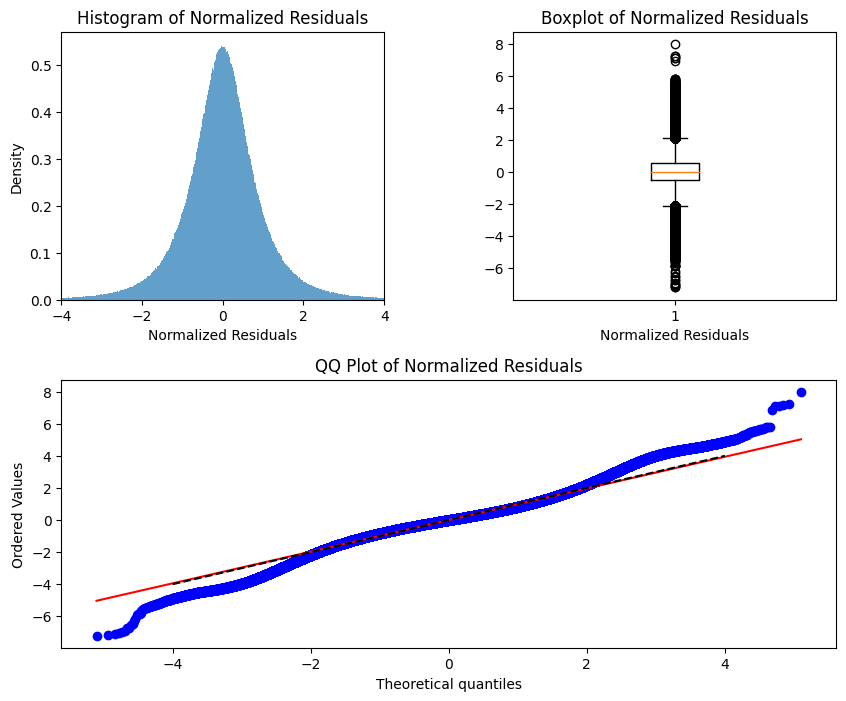

In [42]:
residuals_analysis(model_sigma4.resid)

In [43]:
y_pred_sigma4 = model_sigma4.predict(X_test)

# Compute squared residuals
residuals = y_pred_sigma4 - y_test

# Calculate Mean Absolute Error
mae_sigma4 = mean_absolute_error(y_test, y_pred_sigma4)
print(f"Mean Absolute Error: {mae_sigma4}")

# Calculate and print Squared Error
squared_error_sigma4 = np.mean((y_pred_sigma4 - y_test)**2)
print(f"Mean Squared Error:  {squared_error_sigma4}")

Mean Absolute Error: 6.018759341786468
Mean Squared Error:  80.2688956747548


### 3 $\sigma$ Region

In [44]:
# Define sigma region
sigma_region = train_data[(train_data.target > mean_target - 3 * std_target) & (train_data.target < mean_target + 3 * std_target)]
# Create MLFlow dataset for log
sigma3_dataset = mlflow.data.from_pandas(sigma_region, name='Sigma 3 Dataset Train')

with mlflow.start_run(run_name='Linear Model - Sigma 3'):
    mlflow.set_tag('model_name', 'sigma_3_linear_model')
    
    # Fit the model on training data
    model_sigma3 = smf.ols(formula, 
                       data=sigma_region)
    
    model_sigma3 = model_sigma3.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v1, 'Full Model') # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(sigma3_dataset)

    # compute and log test set metrics
    y_pred_sigma = model_sigma3.predict(X_test)
    
    sigma3_mae = mean_absolute_error(y_test, y_pred_sigma)
    sigma3_mse = mean_squared_error(y_test, y_pred_sigma)

    mlflow.log_metric('test_mae', sigma3_mae)
    mlflow.log_metric('test_mse', sigma3_mse)


/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [45]:
display_anova_table(model_sigma3)

Analysis of Variance Table

+----------------------+---------+-----------+---------+----------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F     |  PR(>F)   |
+----------------------+---------+-----------+---------+----------+-----------+
| imbalance_flag_neg_1 |    1    |   63349   |  63349  |  1017.8  | 2.61e-223 |
|   imbalance_flag_0   |    1    |   13341   |  13341  |  214.4   | 1.55e-48  |
|   imbalance_flag_1   |    1    |     1     |    1    |   0.0    | 8.85e-01  |
|    imbalance_size    |    1    |    633    |   633   |   10.2   | 1.42e-03  |
|   reference_price    |    1    |   72328   |  72328  |  1162.0  | 1.18e-254 |
|     matched_size     |    1    |   1667    |  1667   |   26.8   | 2.26e-07  |
|      bid_price       |    1    |  146701   | 146701  |  2356.9  | 0.00e+00  |
|       bid_size       |    1    |  122827   | 122827  |  1973.3  | 0.00e+00  |
|      ask_price       |    1    |   73553   |  73553  |  1181.7  | 6.28e-259 |
|       ask_

Lilliefors Statistic: 0.03940594804005215
P-value: 0.0009999999999998899


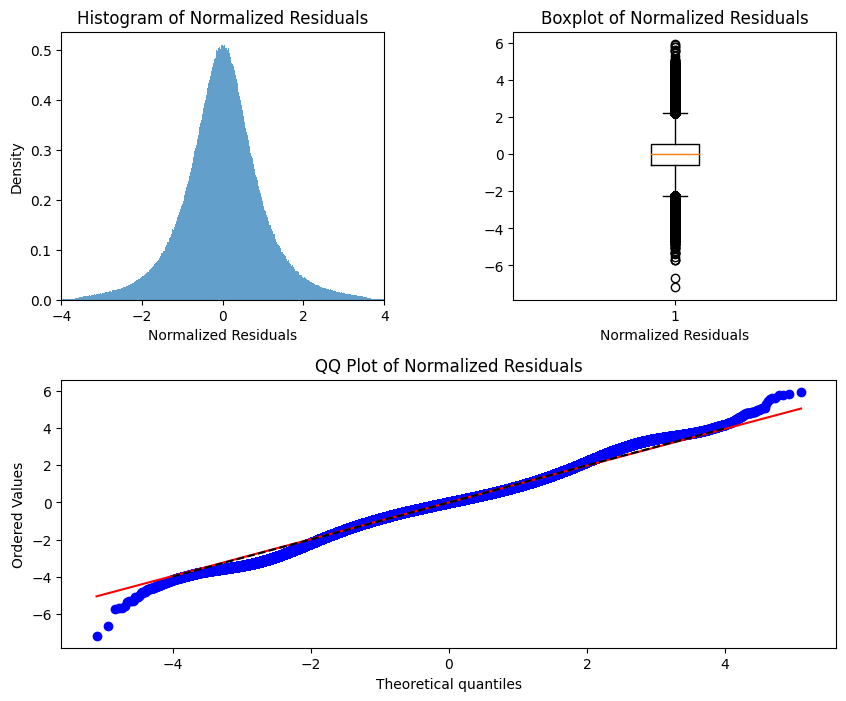

In [46]:
residuals_analysis(model_sigma3.resid)

In [47]:
y_pred_sigma3 = model_sigma3.predict(X_test)

# Compute squared residuals
residuals = y_pred_sigma3 - y_test

# Calculate Mean Absolute Error
mae_sigma3 = mean_absolute_error(y_test, y_pred_sigma3)
print(f"Mean Absolute Error: {mae_sigma3}")

# Calculate and print Squared Error
squared_error_sigma3 = np.mean((y_pred_sigma3 - y_test)**2)
print(f"Mean Squared Error:  {squared_error_sigma3}")

Mean Absolute Error: 6.01600231144421
Mean Squared Error:  80.16991172969406


### 2 $\sigma$ Region

In [48]:
# Define sigma region
sigma_region = train_data[(train_data.target > mean_target - 2 * std_target) & (train_data.target < mean_target + 2 * std_target)]
# Create MLFlow dataset for log
sigma2_dataset = mlflow.data.from_pandas(sigma_region, name='Sigma 2 Dataset Train')

with mlflow.start_run(run_name='Linear Model - Sigma 2'):
    mlflow.set_tag('model_name', 'sigma_2_linear_model')
    
    # Fit the model on training data
    model_sigma2 = smf.ols(formula, 
                       data=sigma_region)
    
    model_sigma2 = model_sigma2.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v1, 'Full Model') # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(sigma2_dataset)

    # compute and log test set metrics
    y_pred_sigma = model_sigma2.predict(X_test)
    
    sigma2_mae = mean_absolute_error(y_test, y_pred_sigma)
    sigma2_mse = mean_squared_error(y_test, y_pred_sigma)

    mlflow.log_metric('test_mae', sigma2_mae)
    mlflow.log_metric('test_mse', sigma2_mse)


/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [49]:
display_anova_table(model_sigma2)

Analysis of Variance Table

+----------------------+---------+-----------+---------+---------+-----------+
|        Source        |   Df    |    SS     |   MS    |    F    |  PR(>F)   |
+----------------------+---------+-----------+---------+---------+-----------+
| imbalance_flag_neg_1 |    1    |   45655   |  45655  |  988.7  | 5.35e-217 |
|   imbalance_flag_0   |    1    |   6867    |  6867   |  148.7  | 3.31e-34  |
|   imbalance_flag_1   |    1    |    47     |   47    |   1.0   | 3.09e-01  |
|    imbalance_size    |    1    |    378    |   378   |   8.2   | 4.20e-03  |
|   reference_price    |    1    |   34159   |  34159  |  739.8  | 6.94e-163 |
|     matched_size     |    1    |   2180    |  2180   |  47.2   | 6.31e-12  |
|      bid_price       |    1    |   68696   |  68696  | 1487.7  | 0.00e+00  |
|       bid_size       |    1    |   84603   |  84603  | 1832.2  | 0.00e+00  |
|      ask_price       |    1    |   37322   |  37322  |  808.3  | 8.87e-178 |
|       ask_size       |

Lilliefors Statistic: 0.01892713734363005
P-value: 0.0009999999999998899


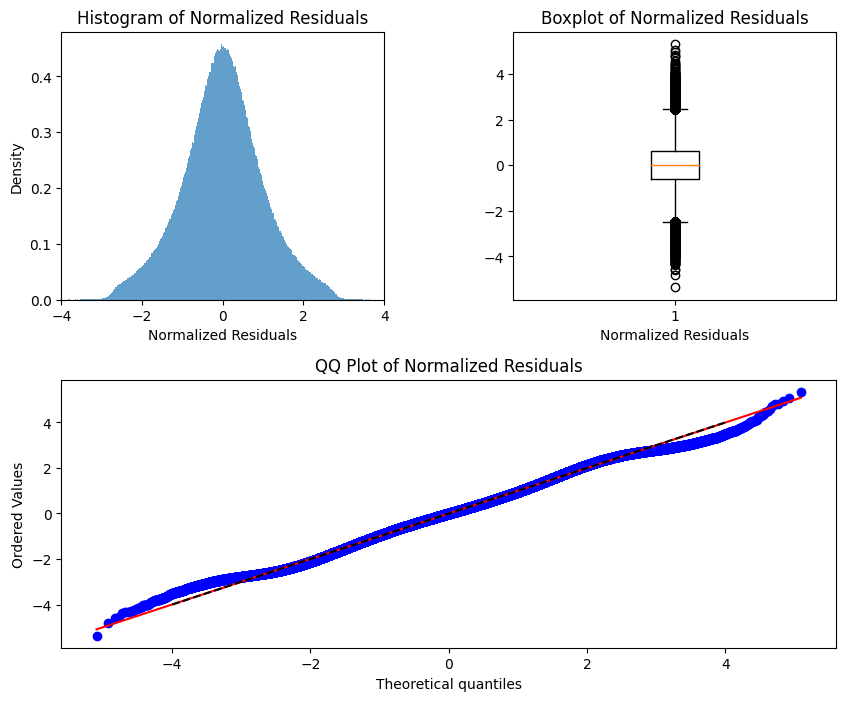

In [50]:
residuals_analysis(model_sigma2.resid)

In [51]:
y_pred_sigma2 = model_sigma2.predict(X_test)

# Compute squared residuals
residuals = y_pred_sigma2 - y_test

# Calculate Mean Absolute Error
mae_sigma2 = mean_absolute_error(y_test, y_pred_sigma2)
print(f"Mean Absolute Error: {mae_sigma2}")

# Calculate and print Squared Error
squared_error_sigma2 = np.mean((y_pred_sigma2 - y_test)**2)
print(f"Mean Squared Error:  {squared_error_sigma2}")

Mean Absolute Error: 6.013371031812083
Mean Squared Error:  80.0511349771523


### 1 $\sigma$ Region

In [52]:
# Define sigma region
sigma_region = train_data[(train_data.target > mean_target - 1 * std_target) & (train_data.target < mean_target + 1 * std_target)]
# Create MLFlow dataset for log
sigma1_dataset = mlflow.data.from_pandas(sigma_region, name='Sigma 1 Dataset Train')

with mlflow.start_run(run_name='Linear Model - Sigma 1'):
    mlflow.set_tag('model_name', 'sigma_1_linear_model')
    
    # Fit the model on training data
    model_sigma1 = smf.ols(formula, 
                       data=sigma_region)
    
    model_sigma1 = model_sigma1.fit()

    # log model onto MLFlow
    # mlflow.statsmodels.log_model(model_v1, 'Full Model') # - commented this line because models are taking too much space!

    # log dataset
    mlflow.log_input(sigma1_dataset)

    # compute and log test set metrics
    y_pred_sigma = model_sigma1.predict(X_test)
    
    sigma1_mae = mean_absolute_error(y_test, y_pred_sigma)
    sigma1_mse = mean_squared_error(y_test, y_pred_sigma)

    mlflow.log_metric('test_mae', sigma1_mae)
    mlflow.log_metric('test_mse', sigma1_mse)


/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/digest_utils.py:26: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  string_columns = trimmed_df.columns[(df.applymap(type) == str).all(0)]
/Users/thomasgaehtgens/.pyenv/versions/3.11.4/lib/python3.11/site-packages/mlflow/data/pandas_dataset.py:134: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-w

In [53]:
display_anova_table(model_sigma1)

Analysis of Variance Table

+----------------------+---------+----------+--------+---------+-----------+
|        Source        |   Df    |    SS    |   MS   |    F    |  PR(>F)   |
+----------------------+---------+----------+--------+---------+-----------+
| imbalance_flag_neg_1 |    1    |  10291   | 10291  |  502.1  | 3.34e-111 |
|   imbalance_flag_0   |    1    |   1726   |  1726  |  84.2   | 4.41e-20  |
|   imbalance_flag_1   |    1    |    25    |   25   |   1.3   | 2.60e-01  |
|    imbalance_size    |    1    |   172    |  172   |   8.4   | 3.72e-03  |
|   reference_price    |    1    |   6307   |  6307  |  307.8  | 6.75e-69  |
|     matched_size     |    1    |   964    |  964   |  47.1   | 6.89e-12  |
|      bid_price       |    1    |   8292   |  8292  |  404.6  | 5.59e-90  |
|       bid_size       |    1    |  18431   | 18431  |  899.3  | 1.49e-197 |
|      ask_price       |    1    |   4765   |  4765  |  232.5  | 1.71e-52  |
|       ask_size       |    1    |  19511   | 19

Lilliefors Statistic: 0.021957795649601736
P-value: 0.0009999999999998899


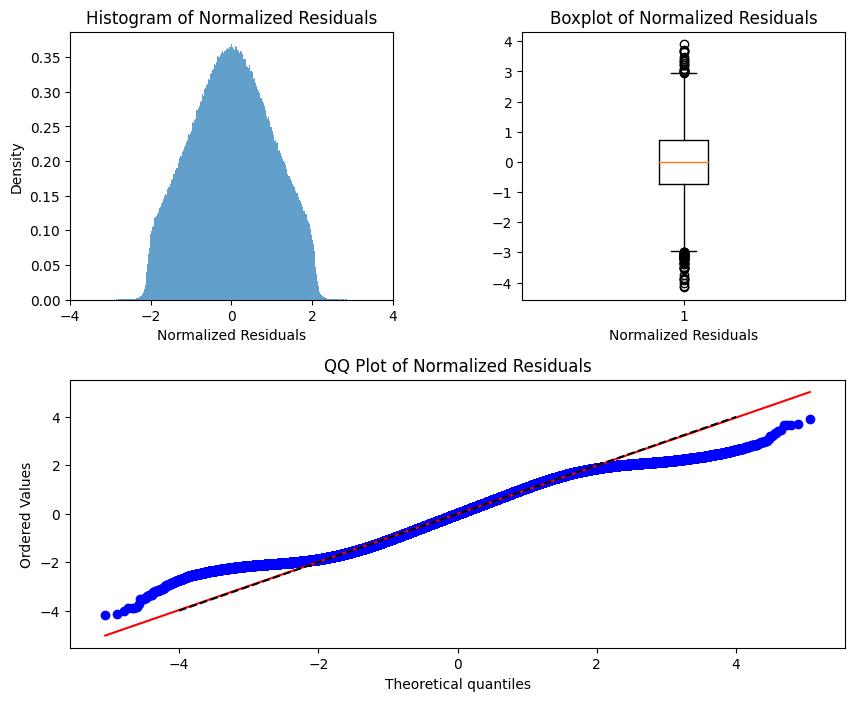

In [54]:
residuals_analysis(model_sigma1.resid)

In [55]:
y_pred_sigma1 = model_sigma1.predict(X_test)

# Compute squared residuals
residuals = y_pred_sigma1 - y_test

# Calculate Mean Absolute Error
mae_sigma1 = mean_absolute_error(y_test, y_pred_sigma1)
print(f"Mean Absolute Error: {mae_sigma1}")

# Calculate and print Squared Error
squared_error_sigma1 = np.mean((y_pred_sigma1 - y_test)**2)
print(f"Mean Squared Error:  {squared_error_sigma1}")

Mean Absolute Error: 6.023897368232478
Mean Squared Error:  80.22686145049214


# Model for Each Stock

In [56]:
from tqdm import tqdm
from sklearn.linear_model import LinearRegression

# Initialize an empty dictionary to store models and MAEs
models = {}
maes = {}

# Get unique stock_ids
stock_ids = train_data['stock_id'].unique()

# model features list
features_list = ['seconds_in_bucket', 
                 'imbalance_size', 
                 'reference_price', 
                 'matched_size',
                 'far_price', 
                 'near_price', 
                 'bid_price', 
                 'bid_size', 
                 'ask_price', 
                 'ask_size',
                 'wap', 
                 'imbalance_flag_neg_1', 
                 'imbalance_flag_0', 
                 'imbalance_flag_1',
                 # Extra Feautres
                 'liquidity_imbalance', 
                 'matched_imbalance', 
                 'price_spread', 
                 'market_urgency']

# Initialize a list to store all MAEs
all_maes = []

# Initialize tqdm
pbar = tqdm(total=len(stock_ids), desc='Calculating MAEs')

# Loop over each stock_id
for stock_id in stock_ids:
    # Subset the data for the current stock_id
    train_subset = train_data[train_data['stock_id'] == stock_id]
    test_subset = test_data[test_data['stock_id'] == stock_id]
    
    x_test_subset = test_subset.drop('target', axis=1)
    y_test_subset = test_subset['target']

    # Extract features and target
    x_train = train_subset.drop('target', axis=1)
    y_train = train_subset['target']

    # Initialize and fit the model
    model = LinearRegression()
    model.fit(x_train[features_list], y_train)

    # Store the model
    models[stock_id] = model

    # Predict on test data
    y_pred = model.predict(x_test_subset[features_list])

    # Calculate MAE
    mae = mean_absolute_error(y_test_subset, y_pred)

    # Store the MAE
    maes[stock_id] = mae

    # Append the MAE to all_maes
    all_maes.append(mae)

    # Update the description of the progress bar to show the rolling mean of MAEs
    pbar.set_description(f'Mean MAE: {round(np.mean(all_maes), 4)}')

    # Update the progress bar
    pbar.update()

# Close the progress bar
pbar.close()

Mean MAE: 6.0224: 100%|███████████████████████| 200/200 [00:12<00:00, 15.60it/s]


# Models Performance

In [57]:
# Generate predictions for each model
y_pred_v1 = model_v1.predict(X_test)
y_pred_v2 = model_v2.predict(X_test)
y_pred_step_v1 = model_step_v1.predict(X_test)
y_pred_step_v2 = model_step_v2.predict(X_test)
y_pred_sigma4 = model_sigma4.predict(X_test)
y_pred_sigma3 = model_sigma3.predict(X_test)
y_pred_sigma2 = model_sigma2.predict(X_test)
y_pred_sigma1 = model_sigma1.predict(X_test)

# Calculate metrics for each model
metrics = []

# Calculate baseline metrics
baseline_mae = mean_absolute_error(y_test, train_data.target.median() * np.ones(len(y_test)))
baseline_mse = mean_squared_error(y_test, train_data.target.median() * np.ones(len(y_test)))

for name, y_pred in [("baseline", train_data.target.median() * np.ones(len(y_test))),
                     ("model_v1", y_pred_v1),
                     ("model_v2", y_pred_v2),
                     ("model_step_v1", y_pred_step_v1),
                     ("model_step_v2", y_pred_step_v2),
                     ("model_sigma4", y_pred_sigma4),
                     ("model_sigma3", y_pred_sigma3),
                     ("model_sigma2", y_pred_sigma2),
                     ("model_sigma1", y_pred_sigma1)]:
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    mae_improvement = ((baseline_mae - mae) / baseline_mae) * 100 if baseline_mae != 0 else 0
    metrics.append([name, mae, mse, f"{mae_improvement:.2f}%"])

# Create a tabulated string
headers = ["Model", "MAE", "Squared Error", "MAE Improvement (\%)"]
table_str = tabulate(metrics, headers=headers, tablefmt="pretty")

print('Performance Metrics on Test Set')
print(table_str)

Performance Metrics on Test Set
+---------------+-------------------+-------------------+----------------------+
|     Model     |        MAE        |   Squared Error   | MAE Improvement (\%) |
+---------------+-------------------+-------------------+----------------------+
|   baseline    | 6.061381271349427 | 81.03662959681185 |        0.00%         |
|   model_v1    | 6.023065154237798 | 80.41316890710344 |        0.63%         |
|   model_v2    | 6.026892903060175 | 80.57804610930796 |        0.57%         |
| model_step_v1 | 6.021343519232566 | 80.30293255624079 |        0.66%         |
| model_step_v2 | 6.024035685270154 | 80.46265278332883 |        0.62%         |
| model_sigma4  | 6.018759341786468 | 80.2688956747548  |        0.70%         |
| model_sigma3  | 6.01600231144421  | 80.16991172969406 |        0.75%         |
| model_sigma2  | 6.013371031812083 | 80.0511349771523  |        0.79%         |
| model_sigma1  | 6.023897368232478 | 80.22686145049214 |        0.62%       